In [1]:
from os import path
import pandas as pand
import numpy as nmp
import string, time, score, random, re, sys, nltk, sklearn
from nltk.corpus import stopwords
from scipy.sparse import hstack, coo_matrix, csr_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC, LinearSVC  
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as ploty
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.initializers import Constant
from keras.utils import to_categorical

# scorer & LABELS imported from FNC-1 baseline implementation
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
RELATED = LABELS[0:3]


print("Requirements\n")
print ("Pandas: {}".format(pand.__version__))
print ("Python: {}".format(sys.version))
print ("NLTK: {}".format(nltk.__version__))
print ("Scikit-Learn: {}".format(sklearn.__version__))
print ("Tensorflow: {}".format(tf.__version__))
print ("Numpy: {}".format(nmp.__version__))

Requirements

Pandas: 1.3.5
Python: 3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
NLTK: 3.6.5
Scikit-Learn: 1.0.2
Tensorflow: 2.0.0
Numpy: 1.18.5


Using TensorFlow backend.


In [2]:
# loading the data sets
df_bodies = pand.read_csv("FNC_1_Data/train_bodies.csv")
df_stances = pand.read_csv("FNC_1_Data/train_stances.csv")

# converting BodyID to int type
df_stances['Body ID'] = df_stances['Body ID'].astype(str).astype(int) 
df_bodies['Body ID'] = df_bodies['Body ID'].astype(str).astype(int)


In [3]:
df_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [4]:
df_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
df_bodies=df_bodies.sample(frac = 1) # shuffling the BodyIDs to ensure random sampling
df_bodies.reset_index(drop=True, inplace=True)

# train-test split of BodyIDs in 80:20 ratio
training_ids = df_bodies['Body ID'][:int(0.8 * len(df_bodies))] 
test_ids = df_bodies['Body ID'][int(0.8 * len(df_bodies)):].reset_index(drop=True)


In [6]:
# hyper-parameters
vocab_length=10000
max_headline = 30
max_body = 2000
total_raw_features = 2030

In [7]:
# conversion of both headlines and bodies text into tokens

tokenizer = Tokenizer(num_words=vocab_length, oov_token='<OOV>')
tokenizer.fit_on_texts(df_stances['Headline'].append(df_bodies['articleBody']))
print(tokenizer.num_words)
print(len(tokenizer.word_index))



10000
27874


In [8]:
# assembling the train and test dataframes by combining the bodies and stances over BodyID
tokens_train=[]
tokens_test=[]
for i in range(len(df_stances)):
    body = (df_bodies.loc[df_bodies['Body ID']==df_stances.loc[i]['Body ID']].squeeze())['articleBody']
    if df_stances.loc[i]['Body ID'] in test_ids:
        tokens_test.append([df_stances.loc[i]['Headline'], body , df_stances.loc[i]['Stance']])
    else:
        tokens_train.append([df_stances.loc[i]['Headline'], body , df_stances.loc[i]['Stance']])    
df_tokens_train = pand.DataFrame(tokens_train, columns=['Headline', 'articleBody', 'Stance'])
df_tokens_test = pand.DataFrame(tokens_test, columns=['Headline', 'articleBody', 'Stance'])
labels_test=[]
for i in range(len(tokens_test)):
    labels_test.append(LABELS.index(df_tokens_test.loc[i]['Stance']))
labels_train=[]
for i in range(len(tokens_train)):
    labels_train.append(LABELS.index(df_tokens_train.loc[i]['Stance']))
df_labels_test= nmp.array(labels_test)
df_labels_train = nmp.array(labels_train)

In [9]:
# genertation of feature matrices

train_headline_features_unpad = tokenizer.texts_to_sequences(df_tokens_train['Headline'])
train_headline_features_padded = pad_sequences(train_headline_features_unpad, maxlen=max_headline, padding='post', truncating='post')
train_body_features_unpad = tokenizer.texts_to_sequences(df_tokens_train['articleBody'])
train_body_features_padded = pad_sequences(train_body_features_unpad, maxlen=max_body, padding='post', truncating='post')
train_features = nmp.hstack([train_headline_features_padded, train_body_features_padded])

test_headline_features_unpad = tokenizer.texts_to_sequences(df_tokens_test['Headline'])
test_headline_features_padded = pad_sequences(test_headline_features_unpad, maxlen=max_headline, padding='post', truncating='post')
test_body_features_unpad = tokenizer.texts_to_sequences(df_tokens_test['articleBody'])
test_body_features_padded = pad_sequences(test_body_features_unpad, maxlen=max_body, padding='post', truncating='post')
test_features = nmp.hstack([test_headline_features_padded, test_body_features_padded])


In [10]:
# function that takes the test train splits as inputs along with feature selection & dimension
# reduction parameters and evaluates the fit times, confusion matrices & accuracy scores for
# 4 chosen classifier models
def evaluate_classifiers (X_train, y_train, X_test, y_test, dim_red, feature_selection):
    fs='none'
    dm='none'
    
    if (feature_selection=='chi2' or feature_selection=='mi'):
        if (feature_selection=='chi2'):
            fs='Chi2 with 1000-best features'
            Kbest = SelectKBest(chi2, k=1000)
            Kbest.fit(X_train, y_train)
            X_train = Kbest.transform (X_train)
            X_test = Kbest.transform (X_test)
        if (feature_selection=='mi'):
            fs='Mutual info with 400-best features'
            Kbest = SelectKBest(mutual_info_classif, k=20)      
            Kbest.fit(X_train, y_train)
            X_train = Kbest.transform (X_train)
            X_test = Kbest.transform (X_test)
        if (dim_red=='svd'):
            dm = 'SVD redn to 300 features'
            svd = TruncatedSVD(n_components=300).fit(X_train)
            X_train = svd.transform(X_train)
            X_test = svd.transform(X_test)
        if (dim_red=='pca'):
            dm = 'PCA redn to 300 features'
            pca = PCA(n_components=300).fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)    
        
    begin = time.time()
    my_DT = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)
    end = time.time()
    DT_fit_time = end-begin
    
    begin = time.time()
    my_RFC = RandomForestClassifier(n_estimators=10, random_state=50).fit(X_train, y_train)
    end = time.time()
    RFC_fit_time = end-begin
    
    begin = time.time()
    my_KN = KNeighborsClassifier().fit(X_train, y_train)
    end = time.time()
    KN_fit_time = end-begin
    
    begin = time.time()
    my_SGDC = SGDClassifier(max_iter=50, tol=None).fit(X_train, y_train)
    end = time.time()
    SGDC_fit_time = end-begin
    
    print(f"\n\nClassification Report & Confusion matrix \n(classifier= Decision tree, feature selection = {fs}, dimension reduction = {dm})\n")
    test_predictions_DT = my_DT.predict(X_test)
    print (classification_report(y_test, test_predictions_DT))
    predicted = [LABELS[int(a)] for a in test_predictions_DT]
    actual = [LABELS[int(a)] for a in y_test]
    score_DT = score.report_score(actual, predicted)
    accuracy_DT = accuracy_score(actual,predicted)
    
    print(f"\n\nClassification Report & Confusion matrix \n(classifier= Random Forest, feature selection = {fs}, dimension reduction = {dm})\n")
    test_predictions_RFC = my_RFC.predict(X_test)
    print (classification_report(y_test, test_predictions_RFC))
    predicted = [LABELS[int(a)] for a in test_predictions_RFC]
    actual = [LABELS[int(a)] for a in y_test]
    score_RFC =score.report_score(actual, predicted)
    accuracy_RFC = accuracy_score(actual,predicted)
    
    print(f"\n\nClassification Report & Confusion matrix \n(classifier= KNeighbor, feature selection = {fs}, dimension reduction = {dm})\n")
    test_predictions_KN = my_KN.predict(X_test)
    print (classification_report(y_test, test_predictions_KN))
    predicted = [LABELS[int(a)] for a in test_predictions_KN]
    actual = [LABELS[int(a)] for a in y_test]
    score_KN = score.report_score(actual, predicted)
    accuracy_KN = accuracy_score(actual,predicted)
    
    print(f"\n\nClassification Report & Confusion matrix \n(classifier= SGDC, feature selection = {fs}, dimension reduction = {dm})\n")
    test_predictions_SGDC = my_SGDC.predict(X_test)
    print (classification_report(y_test, test_predictions_SGDC))
    predicted = [LABELS[int(a)] for a in test_predictions_SGDC]
    actual = [LABELS[int(a)] for a in y_test]
    score_SGDC = score.report_score(actual, predicted)
    accuracy_SGDC = accuracy_score(actual,predicted)
    
    fig, ax = ploty.subplots(figsize=(10,5))
    ax2 = ax.twinx()
    ax.set_ylabel('Fit times', color='teal')
    ax2.set_ylabel('Validation Score % (FNC-1 metric)', color='coral')
    x=nmp.arange(4)
    X=['Decision Tree', 'Random Forest', 'KNeighbors', 'SGDC']
    ax.bar(x-0.1, [DT_fit_time, RFC_fit_time, KN_fit_time, SGDC_fit_time],0.2, color=['teal'], label='Fit times')
    ax2.bar(x+0.1, [score_DT, score_RFC, score_KN, score_SGDC], 0.2,  color=['coral'], label='Accuracy score')
    ax2.set_ylim([0, 100])
    title="feature selection= "+fs+", dim reduction= "+dm
    ploty.title(title)
    ploty.xticks(x, X)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ploty.grid()
    ploty.show()
    
    return [score_DT, score_RFC, score_KN, score_SGDC]


    

### Classification over raw features (2030 features)



Classification Report & Confusion matrix 
(classifier= Decision tree, feature selection = none, dimension reduction = none)

              precision    recall  f1-score   support

           0       0.03      0.15      0.05       142
           1       0.01      0.08      0.01        13
           2       0.04      0.35      0.07       217
           3       0.94      0.54      0.68      5411

    accuracy                           0.52      5783
   macro avg       0.25      0.28      0.20      5783
weighted avg       0.88      0.52      0.64      5783

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    22     |     8     |    34     |    78     |
-------------------------------------------------------------
| disagree  |     2     |     1     |     4     |     6     |
-------------------------------------------------------------
|  d

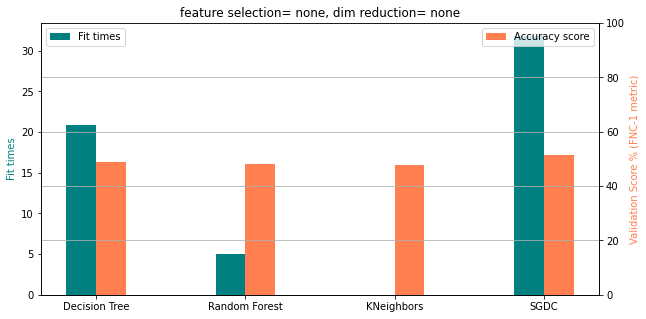

In [11]:
a = evaluate_classifiers (train_features, df_labels_train, test_features, df_labels_test,'NA','NA')

*****
### Classification with feature selcetion (method: Chi-2, 1000-best)



Classification Report & Confusion matrix 
(classifier= Decision tree, feature selection = Chi2 with 1000-best features, dimension reduction = none)

              precision    recall  f1-score   support

           0       0.03      0.18      0.05       142
           1       0.00      0.00      0.00        13
           2       0.05      0.30      0.08       217
           3       0.93      0.55      0.70      5411

    accuracy                           0.53      5783
   macro avg       0.25      0.26      0.21      5783
weighted avg       0.88      0.53      0.65      5783

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    26     |     3     |    23     |    90     |
-------------------------------------------------------------
| disagree  |     3     |     0     |     4     |     6     |
------------------------------------------

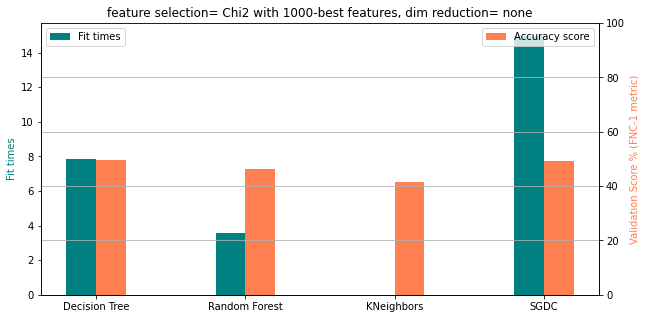

In [12]:
b = evaluate_classifiers (train_features, df_labels_train, test_features, df_labels_test,'NA','chi2')

### Classification with feature selection (Chi2, 1000-best) and dimension reduction (PCA, top 300)



Classification Report & Confusion matrix 
(classifier= Decision tree, feature selection = Chi2 with 1000-best features, dimension reduction = PCA redn to 300 features)

              precision    recall  f1-score   support

           0       0.02      0.20      0.04       142
           1       0.00      0.08      0.00        13
           2       0.04      0.37      0.06       217
           3       0.93      0.28      0.43      5411

    accuracy                           0.28      5783
   macro avg       0.25      0.23      0.14      5783
weighted avg       0.87      0.28      0.41      5783

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    29     |    10     |    55     |    48     |
-------------------------------------------------------------
| disagree  |     4     |     1     |     3     |     5     |
----------------------

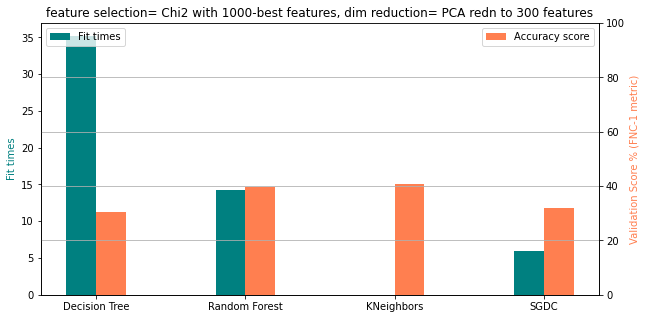

In [13]:
c=evaluate_classifiers (train_features, df_labels_train, test_features, df_labels_test,'pca','chi2')

### Classification with feature selection (Chi2, 1000-best) and dimension reduction (SVD, 300-top)



Classification Report & Confusion matrix 
(classifier= Decision tree, feature selection = Chi2 with 1000-best features, dimension reduction = SVD redn to 300 features)

              precision    recall  f1-score   support

           0       0.02      0.16      0.04       142
           1       0.00      0.08      0.00        13
           2       0.04      0.44      0.08       217
           3       0.94      0.37      0.53      5411

    accuracy                           0.37      5783
   macro avg       0.25      0.26      0.16      5783
weighted avg       0.88      0.37      0.50      5783

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    23     |     8     |    61     |    50     |
-------------------------------------------------------------
| disagree  |     4     |     1     |     5     |     3     |
----------------------

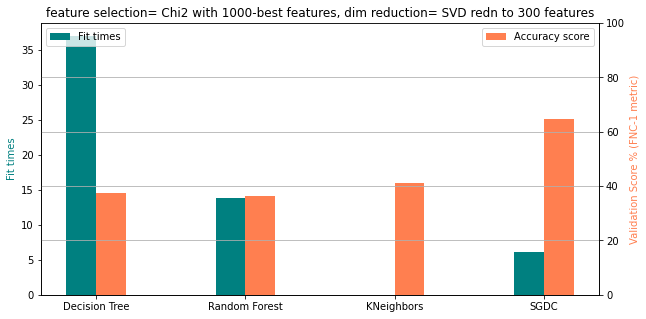

In [14]:
d=evaluate_classifiers (train_features, df_labels_train, test_features, df_labels_test,'svd','chi2')

### Comparision

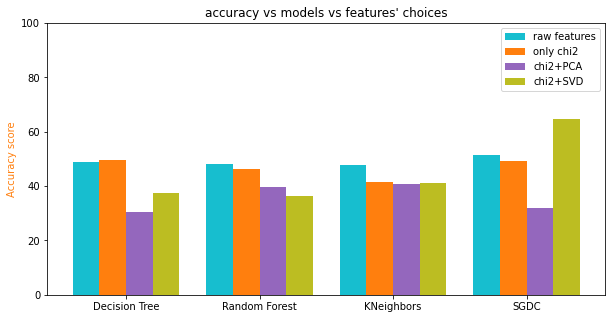

In [15]:
fig, ax = ploty.subplots(figsize=(10,5))
ax.set_ylabel('Accuracy score', color='#ff7f0e')
x=nmp.arange(4)
X=['Decision Tree', 'Random Forest', 'KNeighbors', 'SGDC']
ax.bar(x-0.3, a,0.2, color=['#17becf'], label='raw features')
ax.bar(x-0.1, b,0.2,  color=['#ff7f0e'], label='only chi2')
ax.bar(x+0.1, c,0.2, color=['#9467bd'], label='chi2+PCA')
ax.bar(x+0.3, d,0.2,  color=['#bcbd22'], label='chi2+SVD')
title="accuracy vs models vs features' choices"
ploty.title(title)
ploty.xticks(x, X)
ax.set_ylim([0, 100])
ax.legend(loc='upper right')
ploty.show()

*****
### Classification using GLove embedding
*****

In [16]:
vocab_length=5000
max_headline = 15
max_body = 800

df_stances=df_stances.sample(frac = 0.5) # only picking half samples to ease computational laod
df_stances.reset_index(drop=True, inplace=True)

# train-test split of BodyIDs in 80:20 ratio
training_ids = df_bodies['Body ID'][:int(0.8 * len(df_bodies))] 
test_ids = df_bodies['Body ID'][int(0.8 * len(df_bodies)):].reset_index(drop=True)

# assembling the train and test dataframes by combining the bodies and stances over BodyID
tokens_train=[]
tokens_test=[]
for i in range(len(df_stances)):
    body = (df_bodies.loc[df_bodies['Body ID']==df_stances.loc[i]['Body ID']].squeeze())['articleBody']
    if df_stances.loc[i]['Body ID'] in test_ids:
        tokens_test.append([df_stances.loc[i]['Headline'], body , df_stances.loc[i]['Stance']])
    else:
        tokens_train.append([df_stances.loc[i]['Headline'], body , df_stances.loc[i]['Stance']])    
df_tokens_train = pand.DataFrame(tokens_train, columns=['Headline', 'articleBody', 'Stance'])
df_tokens_test = pand.DataFrame(tokens_test, columns=['Headline', 'articleBody', 'Stance'])
labels_test=[]
for i in range(len(tokens_test)):
    labels_test.append(LABELS.index(df_tokens_test.loc[i]['Stance']))
labels_train=[]
for i in range(len(tokens_train)):
    labels_train.append(LABELS.index(df_tokens_train.loc[i]['Stance']))
df_labels_test= nmp.array(labels_test)
df_labels_train = nmp.array(labels_train)

tokenizer = Tokenizer(num_words=vocab_length, oov_token='<OOV>')
tokenizer.fit_on_texts(df_stances['Headline'].append(df_bodies['articleBody']))

train_headline_features_unpad = tokenizer.texts_to_sequences(df_tokens_train['Headline'])
train_headline_features_padded = pad_sequences(train_headline_features_unpad, maxlen=max_headline, padding='post', truncating='post')
train_body_features_unpad = tokenizer.texts_to_sequences(df_tokens_train['Headline'])
train_body_features_padded = pad_sequences(train_body_features_unpad, maxlen=max_body, padding='post', truncating='post')
train_features = nmp.hstack([train_headline_features_padded, train_body_features_padded])

test_headline_features_unpad = tokenizer.texts_to_sequences(df_tokens_test['Headline'])
test_headline_features_padded = pad_sequences(test_headline_features_unpad, maxlen=max_headline, padding='post', truncating='post')
test_body_features_unpad = tokenizer.texts_to_sequences(df_tokens_test['Headline'])
test_body_features_padded = pad_sequences(test_body_features_unpad, maxlen=max_body, padding='post', truncating='post')
test_features = nmp.hstack([test_headline_features_padded, test_body_features_padded])

In [17]:
embedding_dict = dict()

with open ("glove.42B.300d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = nmp.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vectors

f.close()

embedding_matrix = nmp.zeros((vocab_length+1, 300))

for word, i in tokenizer.word_index.items():
    if i<vocab_length+1:
        embedding_vec = embedding_dict.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec


In [18]:
# a shollow network to make 
model=Sequential()
model.add(
    Embedding(
        vocab_length+1, 
        300, 
        embeddings_initializer = Constant (embedding_matrix),
        input_length=(max_body+max_headline), 
        trainable=False
    )
)
model.add(LSTM(1, dropout=0.2))
model.add(Dense(4,activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-02-15 22:41:46.342476: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-15 22:41:46.348583: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 815, 300)          1500300   
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 1208      
_________________________________________________________________
dense (Dense)                (None, 4)                 8         
Total params: 1,501,516
Trainable params: 1,216
Non-trainable params: 1,500,300
_________________________________________________________________


In [19]:

y_train = df_labels_train
y_test = df_labels_test
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test=to_categorical(y_test)


In [20]:
model.fit(train_features,y_train, epochs=1, verbose=1)

Train on 22143 samples


2022-02-15 22:41:48.794146: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_2956_3441_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_3566' and '__inference___backward_cudnn_lstm_with_fallback_2624_2806' both implement 'lstm_a183d032-a460-4720-a1aa-bf83849ce930' but their signatures do not match.


22143/22143 [==============================] - 1073s 48ms/sample - loss: 1.1756 - accuracy: 0.7021


In [21]:
df_bodies_comp = pand.read_csv("FNC_1_Data/competition_test_bodies.csv")
df_stances_comp = pand.read_csv("FNC_1_Data/competition_test_stances.csv")

df_stances_comp['Body ID'] = df_stances_comp['Body ID'].astype(str).astype(int) 
df_bodies_comp['Body ID'] = df_bodies_comp['Body ID'].astype(str).astype(int)

tokens_test_comp=[]
for i in range(len(df_stances_comp)):
    body = (df_bodies_comp.loc[df_bodies_comp['Body ID']==df_stances_comp.loc[i]['Body ID']].squeeze())['articleBody']
    tokens_test_comp.append([df_stances_comp.loc[i]['Headline'], body , df_stances_comp.loc[i]['Stance']])  
df_tokens_test_comp = pand.DataFrame(tokens_test_comp, columns=['Headline', 'articleBody', 'Stance'])
labels_test_comp=[]
for i in range(len(tokens_test_comp)):
    labels_test_comp.append(LABELS.index(df_tokens_test_comp.loc[i]['Stance']))
df_labels_test_comp= nmp.array(labels_test_comp)

test_comp_headline_features_unpad = tokenizer.texts_to_sequences(df_tokens_test_comp['Headline'])
test_comp_headline_features_padded = pad_sequences(test_comp_headline_features_unpad, maxlen=max_headline, padding='post', truncating='post')
test_comp_body_features_unpad = tokenizer.texts_to_sequences(df_tokens_test_comp['articleBody'])
test_comp_body_features_padded = pad_sequences(test_comp_body_features_unpad, maxlen=max_body, padding='post', truncating='post')
test_comp_features = nmp.hstack([test_comp_headline_features_padded, test_comp_body_features_padded])

y_test_comp = df_labels_test_comp
#y_test_comp =to_categorical(y_test_comp)



In [22]:
pred = model.predict(test_comp_features)



2022-02-15 23:00:07.542796: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_5888' and '__inference_standard_lstm_5888_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_6191' both implement 'lstm_8c7eef8c-1ee9-4bad-9684-428242c18a48' but their signatures do not match.


In [23]:
pred_comp = nmp.array([0 for i in range(len(y_test_comp))])
for i, p in enumerate(pred):
    pred_comp[i] = nmp.argmax(p, axis=0)
    #pred_comp[i] = pred[0][0]*0 + pred[0][1]*1 + pred[0][1]*2 + pred[0][3]*3

In [24]:
predicted = pred_comp
actual = y_test_comp
#score.report_score(actual, predicted)
accuracy_embedding = accuracy_score(actual,predicted)

In [25]:
accuracy_embedding

0.7220320308503522

<Figure size 432x288 with 0 Axes>

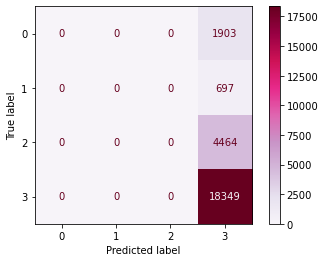

In [26]:
ploty.figure()
disp=ConfusionMatrixDisplay.from_predictions(actual, predicted, cmap='PuRd')
ploty.show()